In [73]:
include("../binary_linalg.jl")
using PyPlot

In [74]:
rand_cliff(n) = binary_random_symplectic_matrix(n)
rand_cc_cliff(n) = binary_charge_conserving_symplectic_mat(n)
id_cliff(n) = diagm(Bool[true for _ in 1:2n])
all_plus(n) = id_cliff(n)[1:2:end, :]

epr_cliff = Bool[1 0 1 0; 0 1 0 0; 0 1 0 1; 0 0 1 0]
inv_epr_cliff = Bool[1 0 0 1; 0 1 0 0; 0 0 0 1; 0 1 1 0]


function b_mat_mult!(m1, m2)
    """
    m1 will be inplacely multiplied by m2 which is a square bmat:
    m1 = m1 * m2
    """
    @assert size(m1, 2) == size(m2, 1) == size(m2, 2)
    m, n = size(m1)
    tmp = zeros(Bool, n)
    @inbounds for i in 1:m
        tmp .= 0
        for k in 1:n, j in 1:n
            tmp[k] ⊻= m1[i, j] * m2[j, k]
        end
        for k in 1:n
            m1[i, k] = tmp[k]
        end
    end
    return nothing
end

function s2b(rg::UnitRange)
    a, b = rg.start, rg.stop
    return 2a-1:2b
end
function s2b(rg)
    l = length(rg)
    result = zeros(Int64, 2l)
    for i in 1:l
        result[2i-1] = 2rg[i]-1
        result[2i] = 2rg[i]
    end
    return result
end


function cliff_on_cliff!(cliff1, cliff2, rg)
    b_rg = s2b(rg)
    tmp = @view cliff2[:, b_rg]
    b_mat_mult!(tmp, cliff1)
    return nothing
end

function cliff_on_state!(cliff, state, rg)
    b_rg = s2b(rg)
    tmp = @view state[:, b_rg]
    b_mat_mult!(tmp, cliff)
    return nothing
end


function rand_cliff_circuit(n, t, gate, periodic)
    cl = id_cliff(n)
    for _ in 1:t
        for ini in [1,2]
            for i in ini:2:(periodic ? n : n-1)
                tmp = gate(2)
                cliff_on_cliff!(tmp, cl, [i, i%n+1])
            end
        end
    end
    return cl
end

    
function cal_2rep_free_energy_given_bc(cliff, lower_bc, upper_bc)
    """
    BC code: 0 for free, 1 for id, 2 for perm (1 2)
    Qubits are arrange as [rep1_in, rep1_out, rep2_in, rep2_out]
    """
    n = div(size(cliff, 1), 2)
    state = all_plus(4n)
    
    for i in 1:n
        if lower_bc[i] == 1
            cliff_on_state!(epr_cliff, state, [0n+i, 1n+i])
            cliff_on_state!(epr_cliff, state, [2n+i, 3n+i])
        elseif lower_bc[i] == 2
            cliff_on_state!(epr_cliff, state, [1n+i, 2n+i])
            cliff_on_state!(epr_cliff, state, [3n+i, 0n+i])
        end
    end
    cliff_on_state!(cliff, state, 0n+1:1n)
    cliff_on_state!(cliff, state, 1n+1:2n)
    cliff_on_state!(cliff, state, 2n+1:3n)
    cliff_on_state!(cliff, state, 3n+1:4n)
    for i in 1:n
        if upper_bc[i] == 1
            cliff_on_state!(inv_epr_cliff, state, [0n+i, 1n+i])
            cliff_on_state!(inv_epr_cliff, state, [2n+i, 3n+i])
        elseif upper_bc[i] == 2
            cliff_on_state!(inv_epr_cliff, state, [1n+i, 2n+i])
            cliff_on_state!(inv_epr_cliff, state, [3n+i, 0n+i])
        end
    end
    
    a, _ = binary_uppertrianglize!(state[:, 2:2:end])
    return length(a)
end    

cal_2rep_free_energy_given_bc (generic function with 1 method)

In [72]:
l_bc = [1, 1, 1, 2, 2, 2, 2]
u_bc = [1, 1, 1, 2, 2, 2, 2]
cl = rand_cliff(7)
# cl = id_cliff(3)

x = cal_2rep_free_energy_given_bc(cl, l_bc, u_bc)

10

In [210]:
b = copy(inv_epr_cliff)
cliff_on_cliff!(copy(epr_cliff), b, [1,2])
b

4×4 Array{Bool,2}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

In [64]:
n = 32
t = 16
periodic = false
gate = rand_cliff

cut_at_s(s, n, left=1, right=2) = Int[(i<=s ? left : right) for i in 1:n]

fs = zeros(n+1)
for _ in 1:100
    cliff = rand_cliff_circuit(n, t, gate, periodic)
    fs += [cal_2rep_free_energy_given_bc(cliff, cut_at_s(i, n), cut_at_s(div(n, 2), n)) for i in 0:n]
end
fs ./= 100;

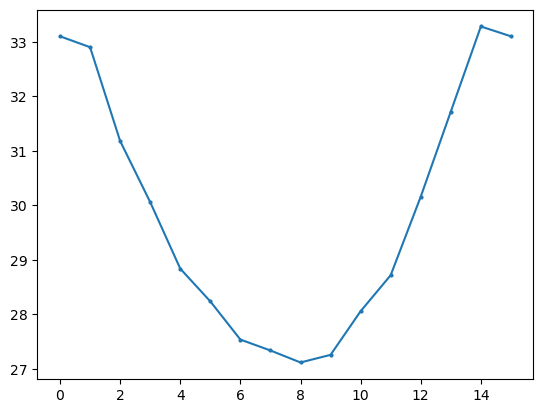

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000140D340>

In [65]:
plot(fs[2:2:end],"-o", ms=2)

In [280]:
cut_at_s(3,6)

6-element Array{Int64,1}:
 1
 1
 1
 2
 2
 2

In [272]:
a = copy(cliff)
a[:, 1:2:end], a[:, 2:2:end] = a[:, 2:2:end], a[:, 1:2:end]
a[1:2:end, :], a[2:2:end, :] = a[2:2:end, :], a[1:2:end, :]

(Bool[1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 1], Bool[1 1 … 0 0; 1 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1])

In [273]:
isodd.(a' * cliff)

128×128 BitArray{2}:
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1     

In [270]:
cliff

128×128 Array{Bool,2}:
 0  0  1  0  0  0  1  0  0  1  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  1  0  1  1  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  1  0  0  1  0  1  0  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  1  1  0  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  1  0  1  1  0  0  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  1  0  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  1  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  1  1  0  0  1  1  1  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  1  1  1  1  1  1  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  1  1  0  0  0  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  1  1  0  1  0  1  0  0  1  0  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  1  0  1  1  0  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  1  1  1  0  0  1  1   